# Doublet Detection

Inspired by DoubletFinder.

In [ ]:
library(SnapATAC)
library(GenomicRanges)
library(ggplot2) 
library(scales)

# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_snATAC
# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_brain_5k

In [328]:
DAYS = c("D10")
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"
BARCODES_PREFIX = "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8"

file.list = c()
barcode.file.list = c()

for (d in DAYS) {
    file.list = c(file.list, sprintf("%s/%s.snap", FILE_PREFIX, d))
    barcode.file.list = c(barcode.file.list, sprintf("%s/%s.barcodes.txt", BARCODES_PREFIX, d))
}
DAYS
file.list
barcode.file.list

[1] "D10"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"

[1] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D10.barcodes.txt"

In [329]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...



In [330]:
# Filter cells using previously selected barcodes (see BarcodeSelection.ipynb)

barcode.list = lapply(barcode.file.list, function(file){
  read.table(file)[,1];
})
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% barcode.list[[i]],];
})
names(x.sp.list) = DAYS;

In [331]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...



In [332]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

In [333]:
x.sp

number of barcodes: 4118
number of bins: 0
number of genes: 0
number of peaks: 467339
number of motifs: 0

In [334]:
dim(x.sp@pmat)

[1]   4118 467339

In [335]:
rm(x.sp.list); # free memory
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,5688551,303.9,10461112,558.7,10461112,558.7
Vcells,1694866287,12930.9,4097334084,31260.2,5078457185,38745.6


In [336]:
black_list = read.table("../20200122_snapATAC/data/hg38.blacklist.bed.gz");
black_list.gr = GRanges(
    black_list[,1], 
    IRanges(black_list[,2], black_list[,3])
  );

In [337]:
idy = queryHits(findOverlaps(x.sp@peak, black_list.gr));

In [338]:
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="pmat"]};

In [339]:
chr.exclude = seqlevels(x.sp@peak)[grep("random|chrM|chrUn", seqlevels(x.sp@peak))];
if (length(chr.exclude)>0) {
idy = grep(paste(chr.exclude, collapse="|"), x.sp@peak);
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="pmat"]}; 
}    

## Make artificial doublets

In [340]:
x.sp.dbl = x.sp

In [341]:
p_doublets = 0.25

In [342]:
N_doublets = as.integer(length(x.sp.dbl@barcode)*p_doublets)
N_doublets

[1] 1029

In [343]:
create_doublet <- function(vi, vj) {
    # creates doublets from two vectors vi, vj
    # takes half the reads/counts from both
    # vi, vj are not necessarily binary
    
    stopifnot(length(vi)==length(vj))
    
    l = length(vi)
    
    # get all "reads" as indices
    vi_reads = rep(seq(1,l), vi)
    vj_reads = rep(seq(1,l), vj)

    # shuffle the reads and take half
    vi_reads = sample(vi_reads)
    vj_reads = sample(vj_reads)    
    
    # get size of each split
    doublet_reads = c(vi_reads[1:ceiling(length(vi_reads)/2)], vj_reads[1:ceiling(length(vj_reads)/2)])
    
    t = table(doublet_reads) # this gives indices and their values
        
    t
}


In [344]:
f = create_doublet(x.sp@pmat[1,], x.sp@pmat[2,])

In [345]:
# simple validation of method
sum(f)
sum(as.numeric(names(f)) %in% which((x.sp@pmat[1,]==0)&(x.sp@pmat[2,]==0)))

[1] 27314

[1] 0

In [346]:
pairs = list()
for (i in seq(N_doublets)) {
    j = sample(seq(1, nrow(x.sp@pmat)),1)
    k = sample(seq(1, nrow(x.sp@pmat)),1)
    pairs[[i]] = c(j,k)
}

In [347]:
get_doublets <- function(l) {
    create_doublet(x.sp@pmat[l[1],], x.sp@pmat[l[2],])
}

artificial_doublets_tables = mclapply(pairs, 
                                      get_doublets, 
                                      mc.cores=40)

In [348]:
sparse_artificial_doublets = sparseMatrix(i = rep(seq(1, length(artificial_doublets_tables)), 
                                                 lapply(artificial_doublets_tables, length)),
                                          j = as.numeric(unlist(lapply(artificial_doublets_tables, names))),
                                          x = unlist(artificial_doublets_tables),
                                          dims = c(N_doublets, ncol(x.sp@pmat)))
rownames(sparse_artificial_doublets) = paste("artificial_doublet", seq(1,N_doublets), sep='_')

In [349]:
head(sparse_artificial_doublets, 2)

2 x 467336 sparse Matrix of class "dgCMatrix"
                                                                              
artificial_doublet_1 . . . . . . . . . . . . . . . . . . . . . . . . . 1 . 1 .
artificial_doublet_2 . . . . . . . . . . . . . . . . . . . . . . . . . 1 . . .
                                     
artificial_doublet_1 . . . . 1 ......
artificial_doublet_2 . . . . . ......

 .....suppressing 467302 columns in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................

In [350]:
# add to pmat
x.sp.dbl@barcode = c(x.sp.dbl@barcode, rownames(sparse_artificial_doublets))
x.sp.dbl@pmat = rbind(x.sp@pmat, sparse_artificial_doublets)

In [351]:
x.sp.dbl

number of barcodes: 5147
number of bins: 0
number of genes: 0
number of peaks: 467336
number of motifs: 0

In [352]:
x.sp.dbl = makeBinary(x.sp.dbl, mat="pmat");

## Cluster

number of barcodes: 5147
number of bins: 0
number of genes: 0
number of peaks: 435690
number of motifs: 0

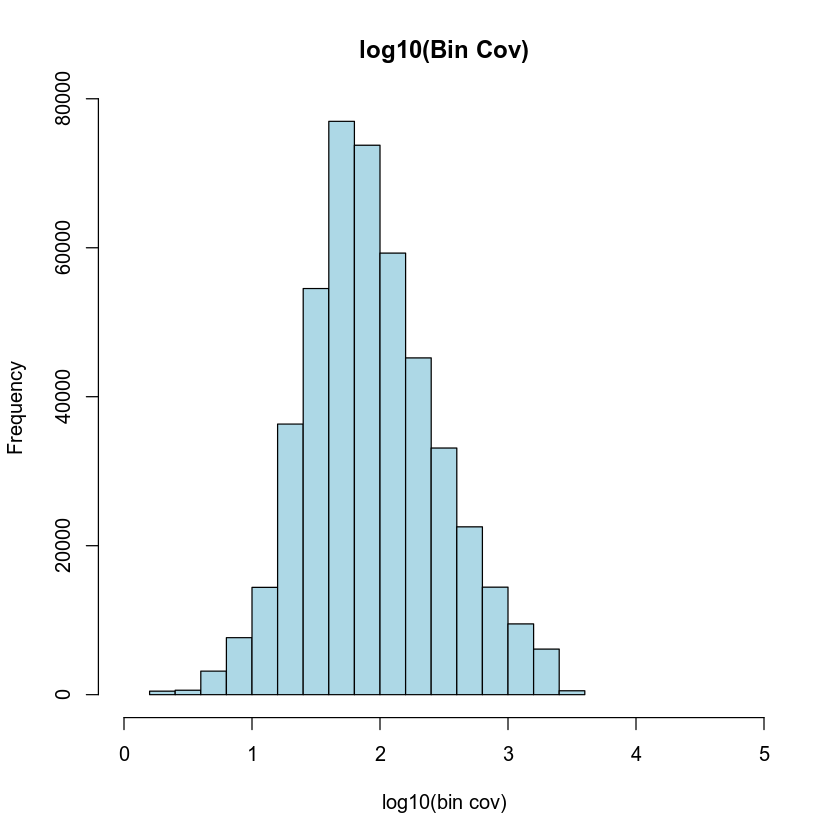

In [353]:
bin.cov = log10(Matrix::colSums(x.sp.dbl@pmat)+1);
hist(
  bin.cov[bin.cov > 0], 
  xlab="log10(bin cov)", 
  main="log10(Bin Cov)", 
  col="lightblue", 
  xlim=c(0, 5)
);
bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95);
idy = which(bin.cov <= bin.cutoff & bin.cov > 0);
x.sp.dbl = x.sp.dbl[, idy, mat="pmat"];
x.sp.dbl

## TODO: fix this in code

In [354]:
# DOES NOT WORK OUT OF THE BOX SINCE bmat is hardcoded in trainRegression
# x.landmark.sp = runDiffusionMaps(
#     obj= x.landmark.sp,
#     input.mat="pmat", 
#     num.eigs=50
# );

In [355]:
# modifying internal functions to make them work for pmat -- buggy now

myTrainRegression <- function(obj){
        row.covs = log(Matrix::rowSums(obj@pmat)+1,10); # EDITED THIS FROM bmat TO pmat
        row.covs.dens <- density(x = row.covs, bw = 'nrd', adjust = 1)
        sampling_prob <- 1 / (approx(x = row.covs.dens$x, y = row.covs.dens$y, xout = row.covs)$y + .Machine$double.eps)
        idx.ds <- sort(sample(x = seq(row.covs), size = min(1000, length(row.covs)), prob = sampling_prob));
        jmat.tr = obj@jmat@jmat[idx.ds,idx.ds];
        b1.tr = obj@jmat@p1[idx.ds];
        b2.tr = obj@jmat@p2[idx.ds];
        # calculate the expected jaccard index matrix given the read depth
        emat.tr = SnapATAC:::.normOVE(b1.tr, b2.tr);
        # estimate the global scaling factor
        data = data.frame(x=emat.tr[upper.tri(emat.tr)], y=jmat.tr[upper.tri(jmat.tr)])	
        model <- lm(y ~ x + I(x^2), data);
        beta1 = as.numeric(model$coefficients)[1]
        beta2 = as.numeric(model$coefficients)[2]
        obj@regModel = c(beta1, beta2);
        rm(jmat.tr);
        rm(emat.tr);
        rm(data);
        rm(model);
        rm(row.covs);
        return(obj)
}


myRunDiffusionMaps <- function(
        obj,
        input.mat=c("bmat", "pmat"), 
        num.eigs=20
){
    nmat.outlier = 0.999
    
    message("Epoch: computing jaccard similarity matrix ...");
    obj = SnapATAC:::runJaccard2(obj, obj, input.mat=input.mat);
    
    message("Epoch: fitting regression model ...");
    obj = myTrainRegression(obj);
    
    message("Epoch: performing normalization ...");
    obj = SnapATAC:::normJaccard(obj, obj@regModel[1], obj@regModel[2]);
    
    # remove the outliers
    nmat.cutoff = quantile(obj@jmat@nmat, nmat.outlier);
    obj@jmat@nmat[obj@jmat@nmat > nmat.cutoff] = nmat.cutoff;
    
    message("Epoch: computing eigen decomposition ...");
    obj = SnapATAC:::runEigDecomp(obj, num.eigs);

    obj@smat@method = "DiffusionMaps";
    message("Epoch: Done");
    return(obj);
}

myRunDiffusionMapsExtension <- function(
        obj1,
        obj2,
        input.mat=c("bmat", "pmat")
){
    data.use.qry = obj2@pmat;
    peak.use.qry = obj2@peak;
        
    message("Epoch: computing jaccard similarity matrix ...");
    obj2 = SnapATAC:::runJaccard2(obj2, obj1, input.mat=input.mat);

    message("Epoch: performing normalization ...");
    obj2 = SnapATAC:::normJaccard(obj2, obj1@regModel[1], obj1@regModel[2])

    # remove the outliers
    nmat.cutoff = max(obj1@jmat@nmat);
    obj2@jmat@nmat[obj2@jmat@nmat > nmat.cutoff] = nmat.cutoff;
    
    message("Epoch: projecting query cells to the reference ...");
    obj2 = SnapATAC:::runEigDecompExd(obj1, obj2);
    
    message("Epoch: Done");
    obj2@pmat = data.use.qry
    obj2@peak = peak.use.qry
    
    return(obj2);
}

In [356]:
x.sp.dbl = myRunDiffusionMaps(
    obj= x.sp.dbl,
    input.mat="pmat", 
    num.eigs=50
);

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



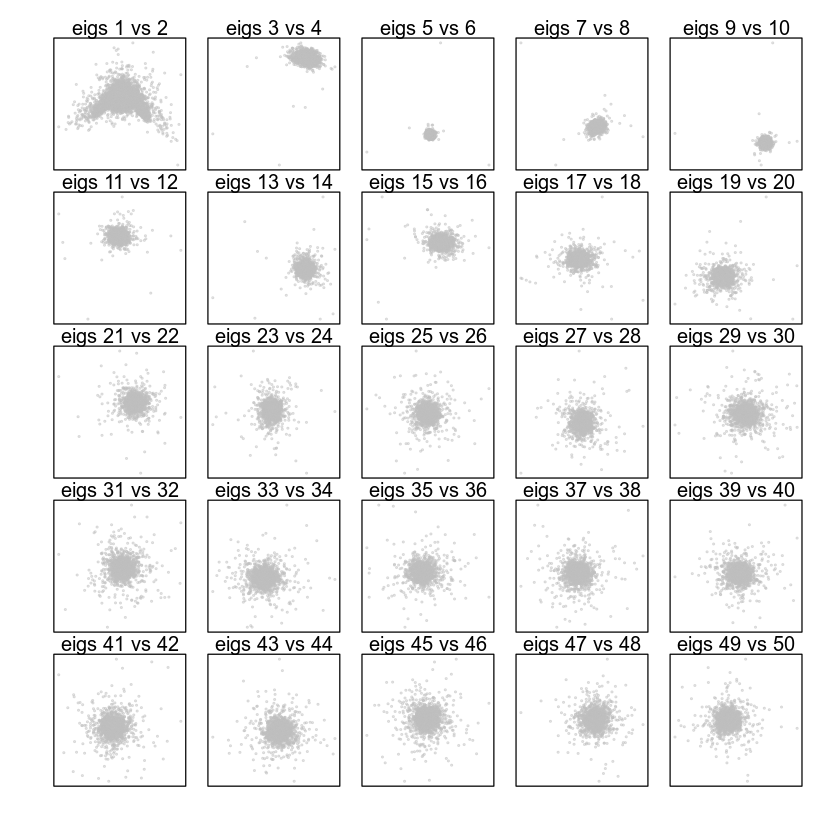

In [357]:
plotDimReductPW(
    obj=x.sp.dbl, 
    eigs.dims=1:50,
    point.size=0.3,
    point.color="grey",
    point.shape=19,
    point.alpha=0.6,
    down.sample=5000,
    pdf.file.name=NULL, 
    pdf.height=7, 
    pdf.width=7
  );

In [358]:
x.sp.dbl = runViz(
    obj=x.sp.dbl, 
    tmp.folder=tempdir(),
    dims=2,
    eigs.dims=1:5, 
    method="umap",
    seed.use=10,
    num.cores=10,
  );

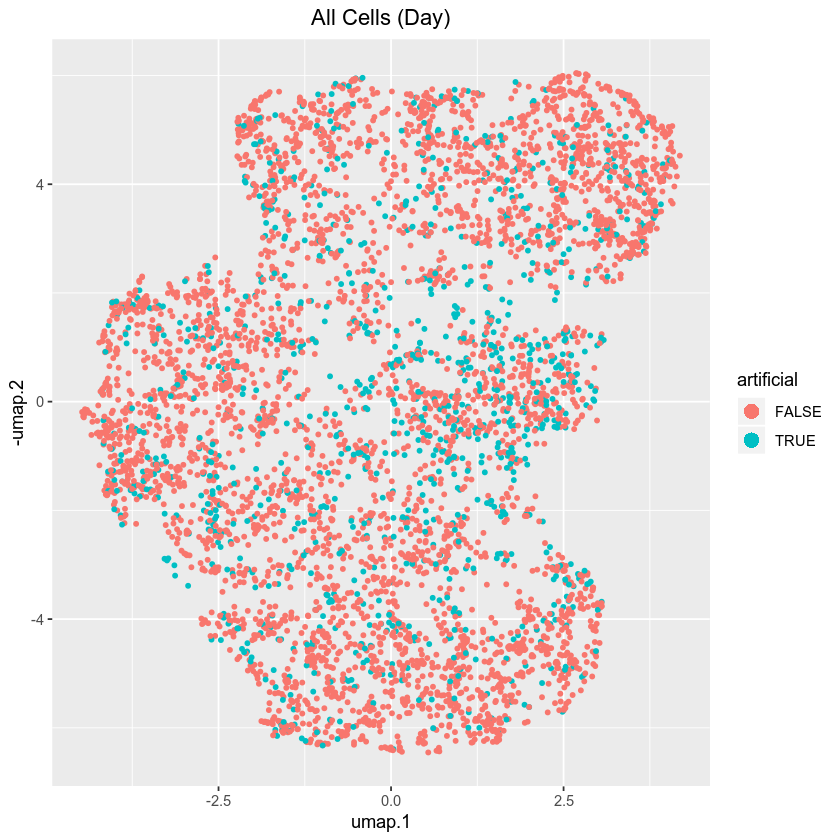

In [359]:
df = data.frame(x.sp.dbl@umap, artificial=grepl("artificial", rownames(x.sp.dbl@pmat)))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=1, alpha=1, aes(x=umap.1 , y=-umap.2, col=artificial)) +
# scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

In [365]:
x.sp.dbl = runKNN(
    obj= x.sp.dbl,
    eigs.dim=1:5,
    k=50
  );

ERROR: Error in nn2(obj = x.sp.dbl, eigs.dim = 1:5, k = 50): could not find function "nn2"


In [381]:
knn_idx = t(apply(x.sp.dbl@graph@mat>0, 1, which))[!grepl("artificial", x.sp.dbl@barcode),]

In [382]:
art_dbl_idx = which(grepl("artificial", x.sp.dbl@barcode))

In [384]:
art_dbl_ngbrs = apply(knn_idx, 1, function(x) {sum(x %in% art_dbl_idx)})

In [388]:
quantile(art_dbl_ngbrs, c(0.05, 0.98))

5% 98% 
  3  20

In [423]:
x.sp@barcode[which(art_dbl_ngbrs>20)]

[1] "AACATCCGACAGCACC" "AACCGGCACTCCGTAA" "ACACATCGATTTCCGC" "ACACTCCACTCGCTAA"
 [5] "ACAGCCGACCCTTTGC" "ACTCGGGACAAATCGA" "ACTTCCTCTGCTGTTA" "ACTTGAGTGGGAATAT"
 [9] "AGAACGCGACTGAGAG" "AGAGCAGTGGAACCTT" "AGAGGGACTAGGGAGG" "AGCTTCCACCCGTGAC"
[13] "AGGAAGCACCCTATCC" "AGGAGGTTGAGATTCC" "ATAGCCAACCCAGCTG" "ATAGGAAACTAACCCA"
[17] "CAATGCCCTGATCATC" "CAGCTGTCTCCTAGCG" "CATTGGAACAAGTTCC" "CATTGTTACTTCTGAG"
[21] "CATTTGTACGAGAGGG" "CCAGCTTTGGTCCCGA" "CCCTCCTGAATACAGG" "CCTAGCACTGCAGGAT"
[25] "CCTCACATGATACGCT" "CCTTCAGTGTGATGAA" "CGCAAAGGAGGGATTG" "CGCAATCCTTTCTGGA"
[29] "CGGTCGATGCAATGAA" "CGGTCGATGGATCATC" "CTCGGATCTACCTAGT" "CTGCTTTCTTTGTTTC"
[33] "CTTAGATCTCATGCGC" "GAAAGTCCTTCGTACA" "GACAGGAACAAGGTGC" "GCATCACCTTCCGTAA"
[37] "GCCCCCCCCCCCCCCC" "GCTGTTCTGGGCCATC" "GGATTTGACGACAAAT" "GGTATGACTAAGTAAC"
[41] "GTACTGCCTCGAAAGC" "GTTGACTGACTGCGGT" "TAACGAGCTGCCCTTT" "TAAGGCTTGATCAGCT"
[45] "TACCTTCCTTAAGTAG" "TCAGACCCTATCAGGG" "TCAGCGCGAGCCCTAG" "TCCCACATGCTCATTT"
[49] "TCCCCCCCCCCCCCCC" "TCCTTCACTAATGCTC" "TCCTTCACTTACCTGA" "TGCGTCTACAGATTCC"
[53] "TGGCGTTCTACAACAA" "TGGTTTGGATCTGCAA" "TGTAAGCTGCTTGAAC" "TGTATTCACAGCCCTG"
[57] "TGTCGAAACTTTGTCT" "TGTCTTCCTCCGGACT" "TGTGGCTCTCTCATCC" "TTCGACCACAAACTGA"
[61] "TTGTCGAGACCTGCGA"

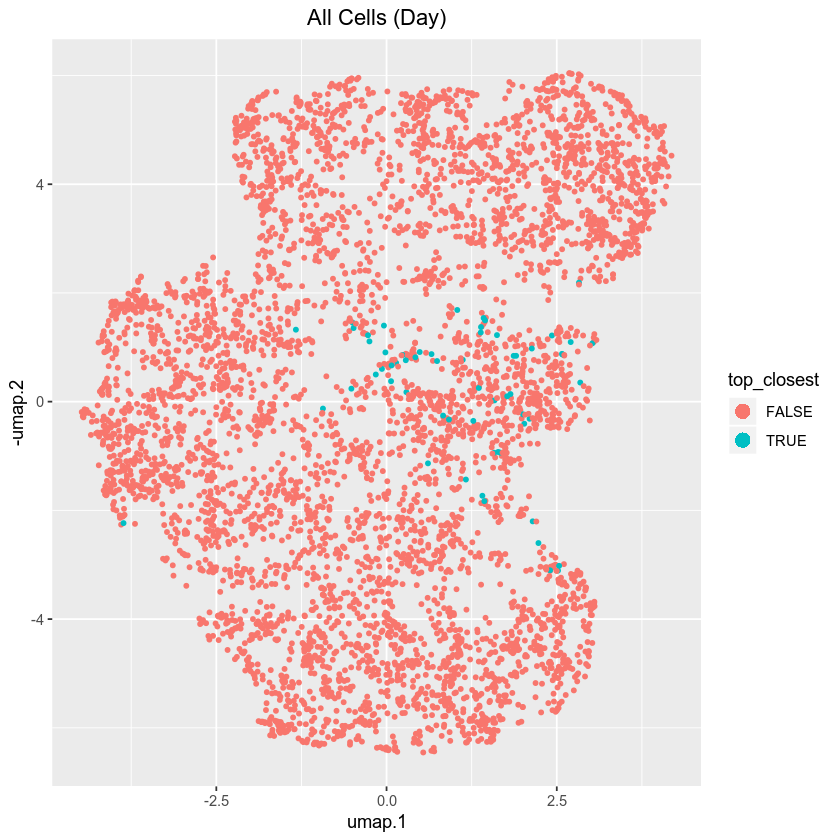

In [398]:
df = data.frame(x.sp.dbl@umap, top_closest=seq(1,nrow(x.sp.dbl)) %in% which(art_dbl_ngbrs>20))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=1, alpha=1, aes(x=umap.1 , y=-umap.2, col=top_closest)) +
# scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

In [455]:
# these are barcodes for D10 that mix with barcodes from other days and clump
# together in the main UMAP. Projecting them in this map to see where they lie.
outlier_cluster_barcodes = read.table("./out/mixed_cells_cluster_barcode_D10.txt")

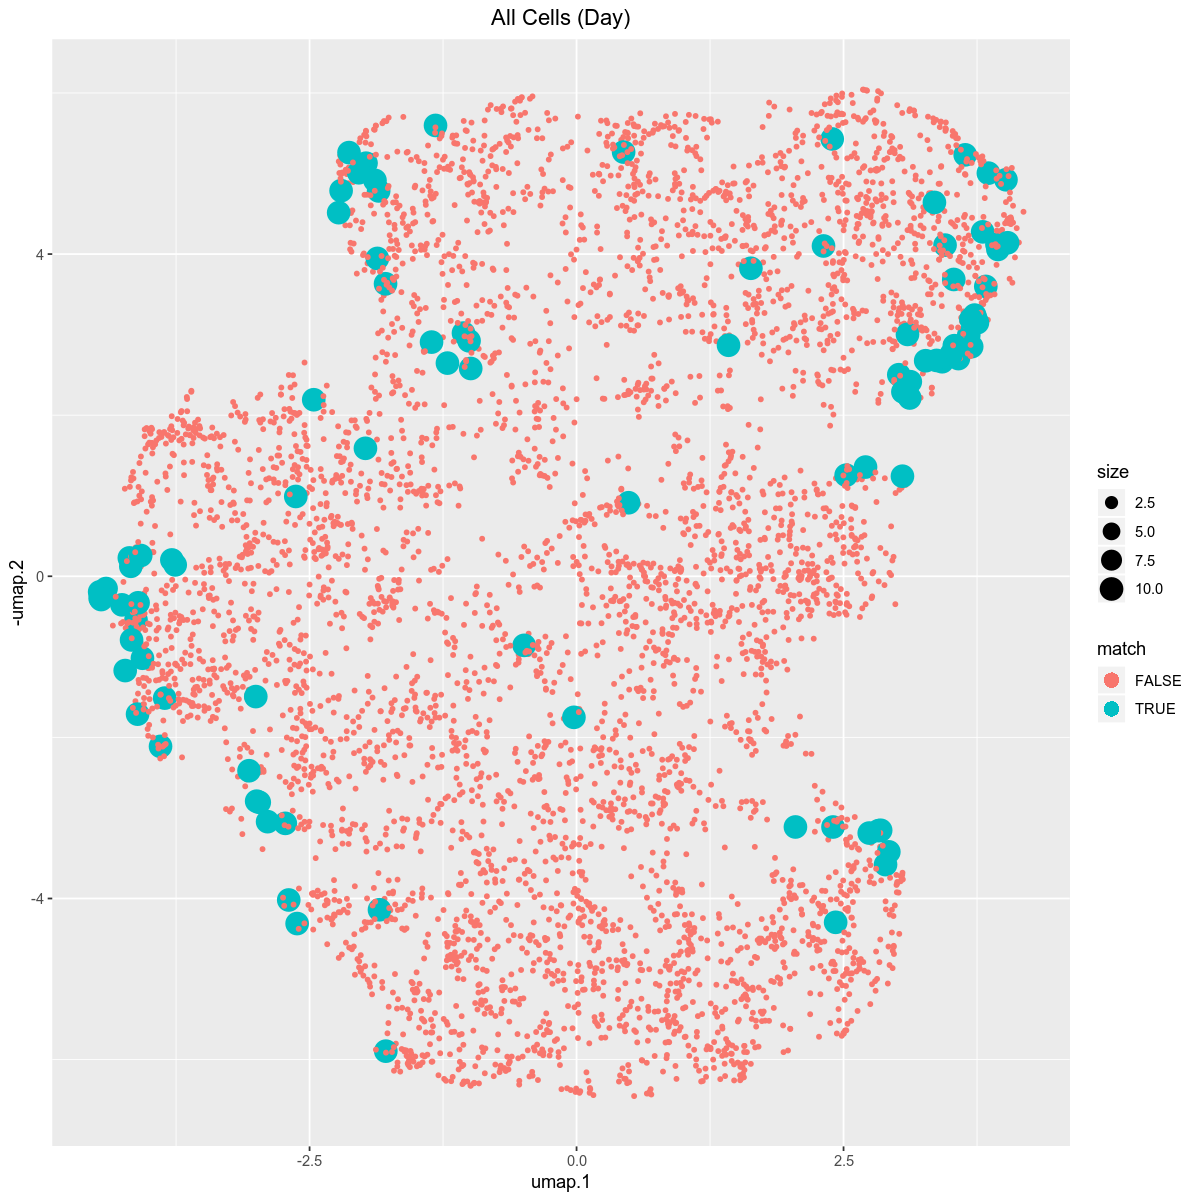

In [438]:
df = data.frame(x.sp.dbl@umap, match=x.sp.dbl@barcode %in% unlist(outlier_cluster_barcodes))
df$size = ifelse(df$match, 10, 1)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(alpha=1, aes(x=umap.1 , y=-umap.2, col=match, size=size)) +
# scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))


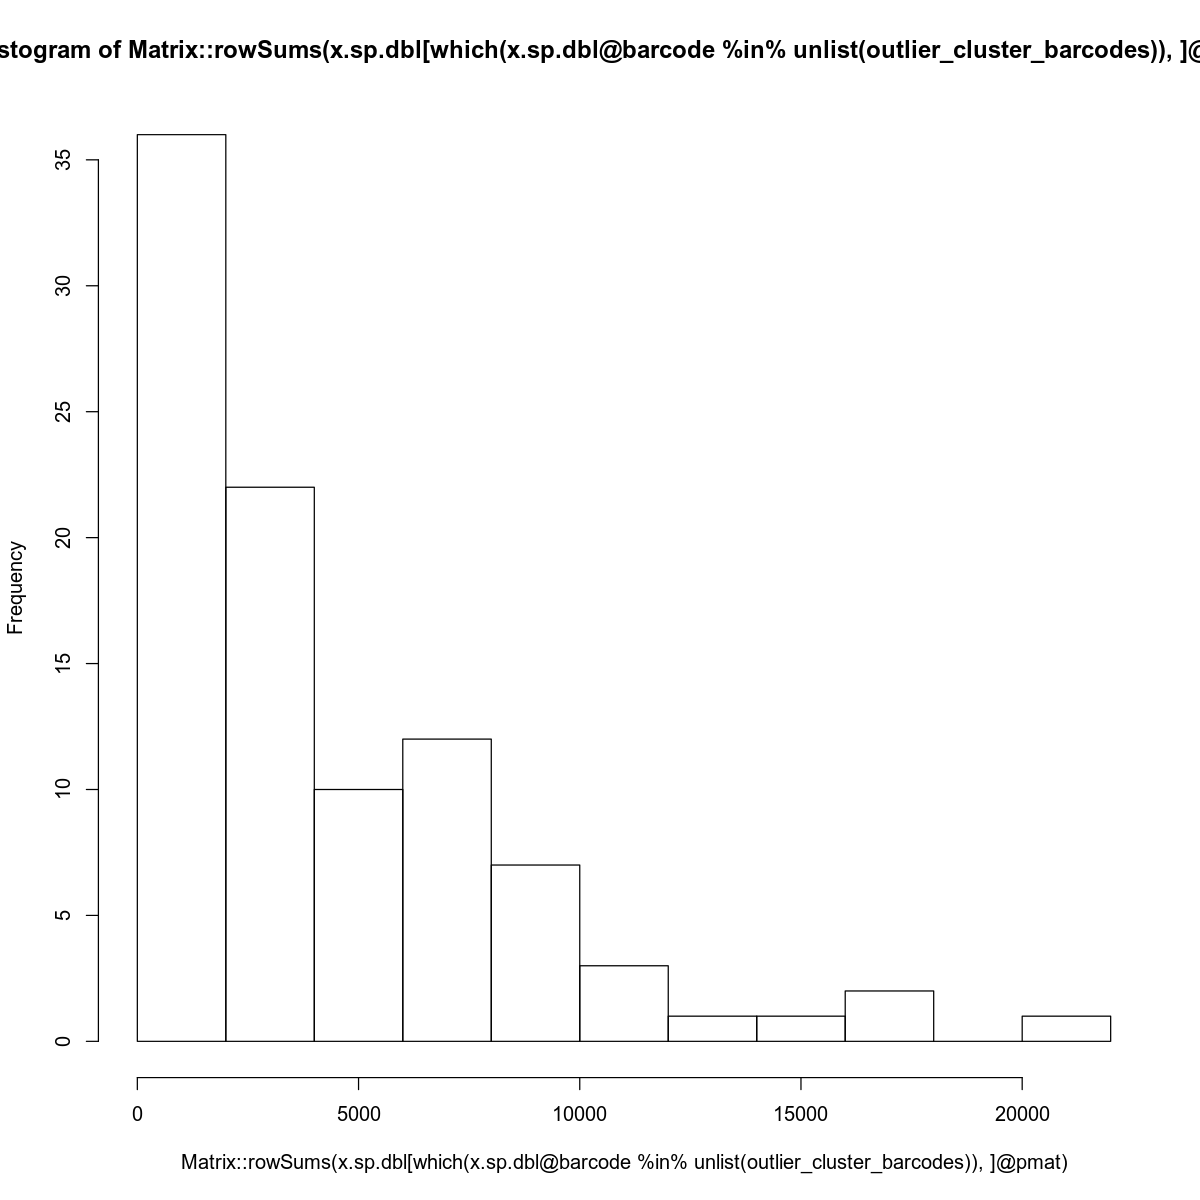

In [443]:
hist(Matrix::rowSums(x.sp.dbl[which(x.sp.dbl@barcode %in% unlist(outlier_cluster_barcodes)),]@pmat))

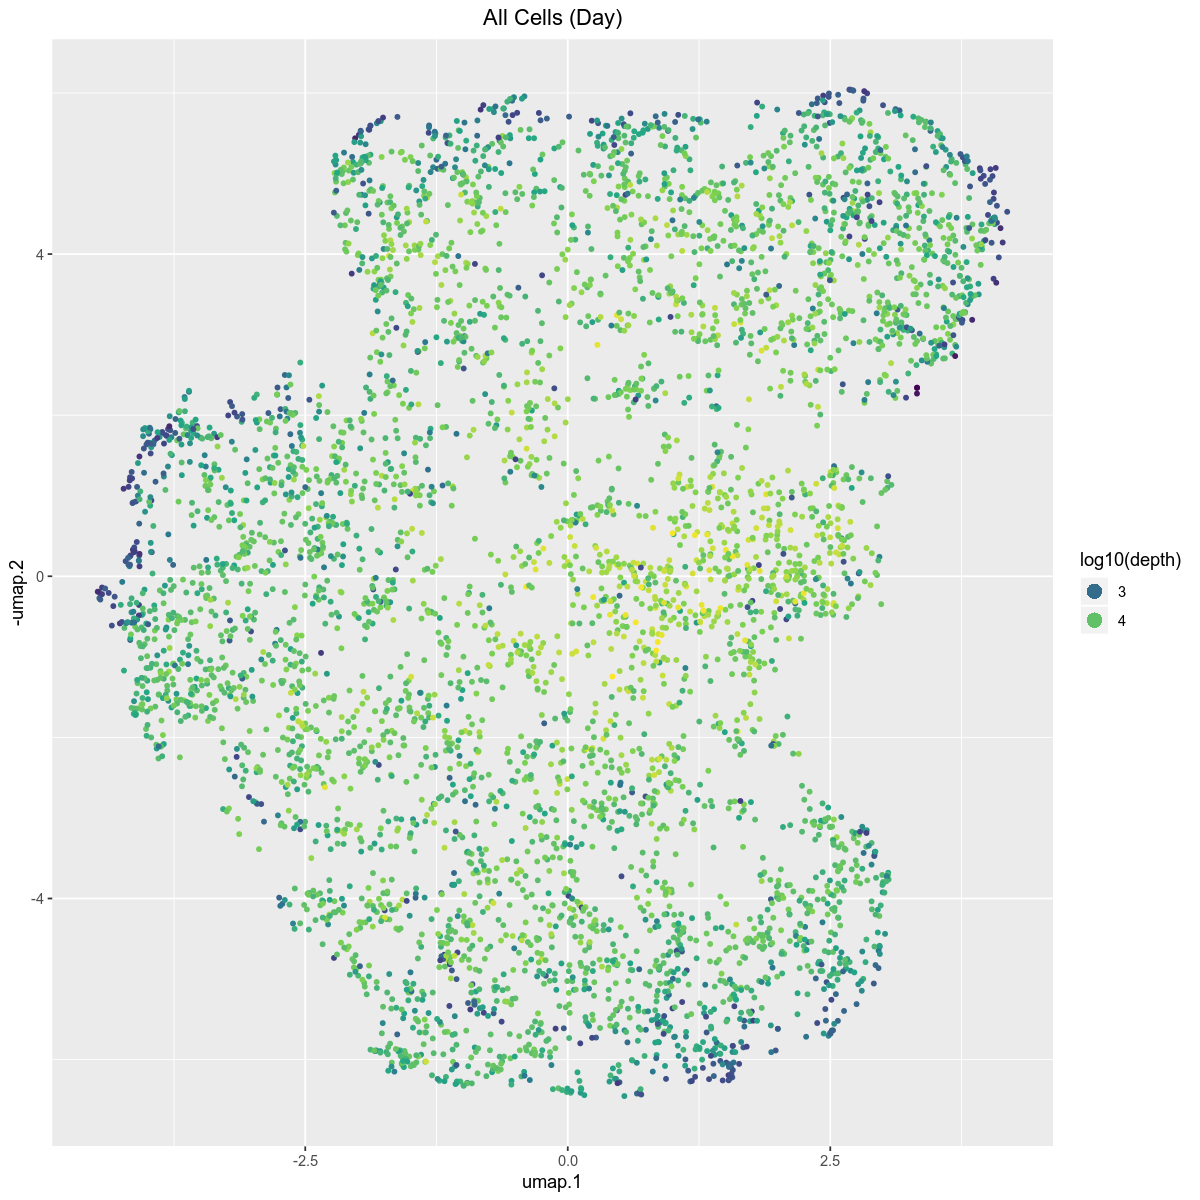

In [419]:
df = data.frame(x.sp.dbl@umap, depth=Matrix::rowSums(x.sp.dbl@pmat))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=1, alpha=1, aes(x=umap.1 , y=-umap.2, col=log10(depth))) +
# scale_color_brewer(breaks=DAYS, palette = "Set1") +
scale_colour_viridis_c() +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

In [401]:
# PCA
nmat = x.sp.dbl@jmat@nmat
nmat.cutoff = quantile(nmat, 0.999);
nmat[nmat>nmat.cutoff] = nmat.cutoff

In [ ]:
pca = prcomp(nmat,center=TRUE,scale=FALSE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)
# pcs$clust_num = as.numeric(lapply(strsplit(pcs$ID, 'cluster'), "[[",2 ))
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained[1:10])

In [413]:
pcs$artificial = grepl("artificial", rownames(x.sp.dbl@pmat))
pcs$depth = Matrix::rowSums(x.sp.dbl@pmat)

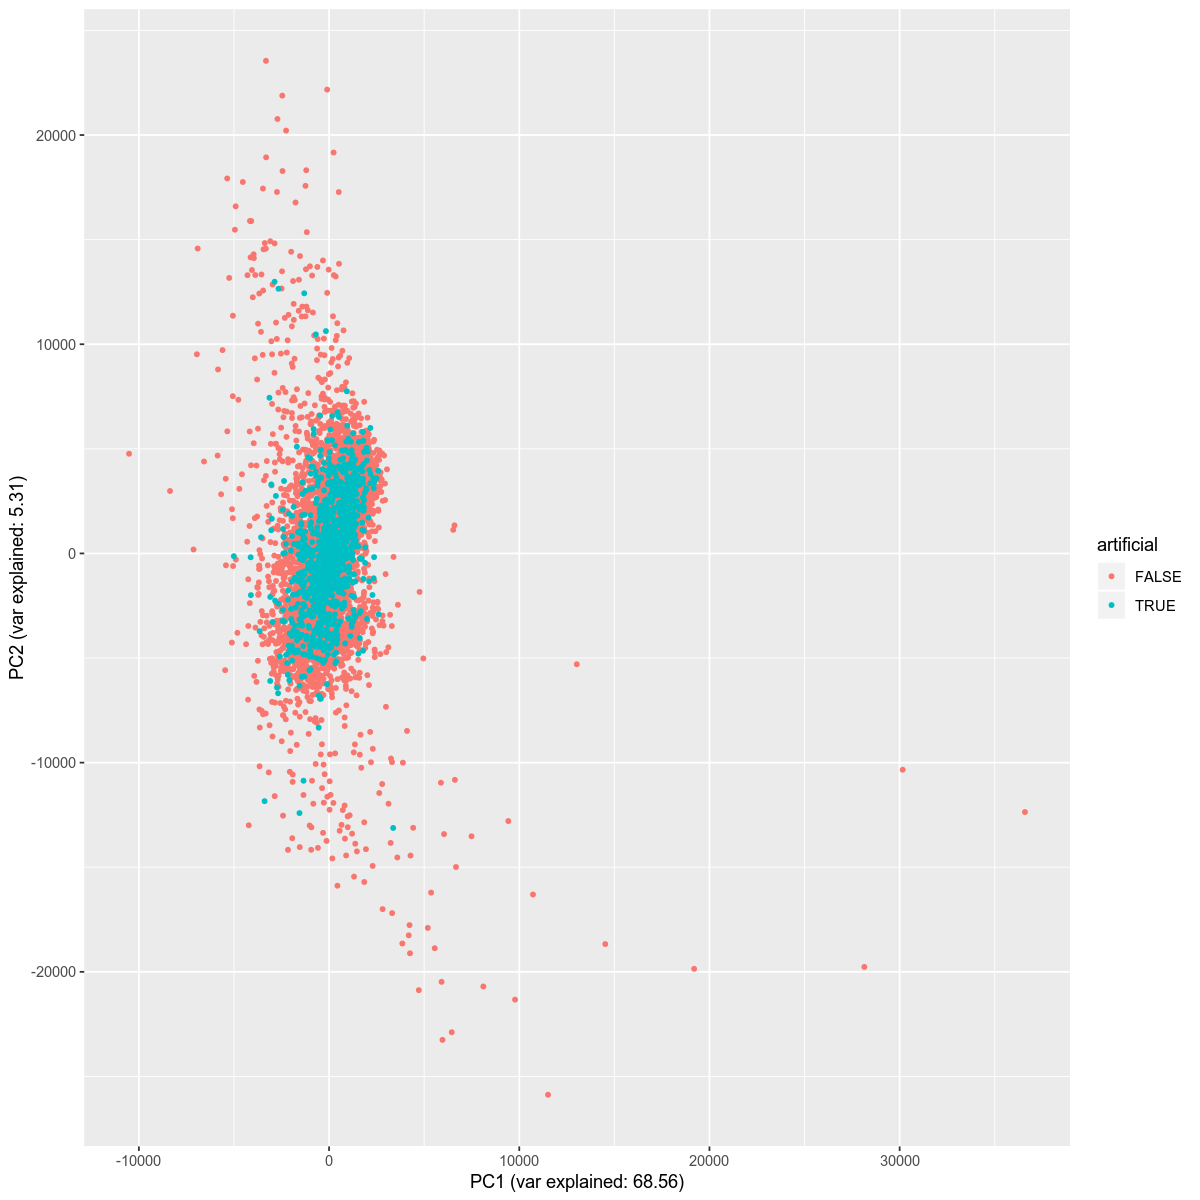

In [422]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(data=pcs,aes(x=PC3,y=PC2,color=artificial))+
geom_point(size=1)+
# scale_color_viridis_c()+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

## Epilogue

The clump consisting of cells from different days in the main UMAP are most likely not doublets, but dead cells or something else. When they are projected onto the UMAP specific to this day, they seem to show up near the edges. There is no clear set of doublets here most likely because these trajectories are continuous and it is hard to differentiate a doublet from an intermediate state. 

As a result, my recommendation for now is to simply remove cells falling in the clump.